# Primary Election Endorsements and Financing

## Setup

In [39]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pymc3 import glm
import statsmodels.api as sm

## Questions

1) (Comparing GLMs and nonparametric methods): What characteristics or political stances would most benefit a candidate in the primary election?

2) (Causal inference): Does increased spending in a swing state cause a positive impact in the election outcome?

## Data

In [2]:
INPUT_PATH = './data/'

file_names = [f for f in os.listdir(INPUT_PATH) if os.path.isfile(os.path.join(INPUT_PATH, f))]
file_names

['senate_spedning.csv',
 'house_spending.csv',
 '2012_independent_expenditures.csv',
 '2020_independent_expenditures.csv',
 '2004_independent_expenditures.csv',
 '2020_pres_spending.csv',
 '2016_independent_expenditures.csv',
 'rep_candidates.csv',
 'dem_candidates.csv',
 '2008_independent_expenditures.csv']

In [3]:
url = "https://raw.githubusercontent.com/fivethirtyeight/data/master/primary-candidates-2018/dem_candidates.csv"
dem = pd.read_csv(url)
dem.head()

,Candidate,State,District,Office Type,Race Type,Race Primary Election Date,Primary Status,Primary Runoff Status,General Status,Partisan Lean,...,Biden Endorsed?,Warren Endorsed?,Sanders Endorsed?,Our Revolution Endorsed?,Justice Dems Endorsed?,PCCC Endorsed?,Indivisible Endorsed?,WFP Endorsed?,VoteVets Endorsed?,No Labels Support?
0,Anthony White (Alabama),AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Christopher Countryman,AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Doug ""New Blue"" Smith",AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,James C. Fields,AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Sue Bell Cobb,AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's read off the `2020_independent_expenditures` from the [FEC dataset](https://www.fec.gov/data/independent-expenditures/?data_type=processed&cycle=2020&is_notice=true&most_recent=true&candidate_office=P). Below are the columns of the provided dataset.

In [4]:
spendings = pd.read_csv(INPUT_PATH + '2020_independent_expenditures.csv')
spendings.head()

/Users/brianlin/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (54,55,67) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,committee_id,committee_name,report_year,report_type,image_number,line_number,file_number,payee_name,payee_first_name,payee_middle_name,...,payee_prefix,payee_suffix,is_notice,most_recent,filing_date,memo_text,filer_prefix,filer_suffix,schedule_type,pdf_url
0,C00341396,MOVEON.ORG POLITICAL ACTION,2020,48,202009139267166288,24.0,1437548,ZERO WEEK SOLUTIONS,NaN,NaN,...,NaN,NaN,t,t,2020-09-13 00:00:00,NaN,NaN,NaN,SE,https://docquery.fec.gov/cgi-bin/fecimg/?20200...
1,C00453704,EMGAGE FEDERAL POLITICAL ACTION COMMITTEE,2020,24,202011069336972545,24.0,1471697,"AL JOUBARI, ALI",ALI,NaN,...,NaN,NaN,t,t,2020-11-06 00:00:00,NaN,NaN,NaN,SE,https://docquery.fec.gov/cgi-bin/fecimg/?20201...
2,C00612846,THE DEMOCRATIC COALITION,2020,24,202010319336677869,24.0,1470276,FACEBOOK,NaN,NaN,...,NaN,NaN,t,t,2020-10-31 00:00:00,NaN,SCOTT,NaN,SE,https://docquery.fec.gov/cgi-bin/fecimg/?20201...
3,C00627372,UNITE HERE PAC,2020,24,202010229326905107,24.0,1461275,UNITE HERE LOCAL 2,NaN,NaN,...,NaN,NaN,t,t,2020-10-22 00:00:00,NaN,NaN,NaN,SE,https://docquery.fec.gov/cgi-bin/fecimg/?20201...
4,C00684530,PLANNED PARENTHOOD OF MINNESOTA POLITICAL ACTI...,2020,24,202011029336739466,24.0,1471187,WIN JUSTICE,NaN,NaN,...,NaN,NaN,t,t,2020-11-02 00:00:00,NaN,NaN,NaN,SE,https://docquery.fec.gov/cgi-bin/fecimg/?20201...


In [5]:
spendings.columns

Index(['committee_id', 'committee_name', 'report_year', 'report_type',
       'image_number', 'line_number', 'file_number', 'payee_name',
       'payee_first_name', 'payee_middle_name', 'payee_last_name',
       'payee_street_1', 'payee_street_2', 'payee_city', 'payee_state',
       'payee_zip', 'previous_file_number', 'amendment_indicator',
       'amendment_number', 'expenditure_description', 'expenditure_date',
       'dissemination_date', 'expenditure_amount', 'office_total_ytd',
       'category_code', 'category_code_full', 'support_oppose_indicator',
       'memo_code', 'memo_code_full', 'candidate_id', 'candidate_name',
       'candidate_prefix', 'candidate_first_name', 'candidate_middle_name',
       'candidate_last_name', 'candidate_suffix', 'candidate_office',
       'candidate_office_state', 'candidate_office_district',
       'candidate_party', 'conduit_committee_id', 'conduit_committee_name',
       'conduit_committee_street1', 'conduit_committee_street2',
       'conduit_

## Data Cleaning

Notice here that there are multiple different entries for the same candidate. For example, we see `Biden` and `Biden Jr` as two different last names for the candidate `Joseph Biden`. We will exclude all other candidates and only focus on the two presidential nomiees, `Trump` and `Biden`.

In [6]:
spendings['candidate_last_name'].value_counts().head(10)

BIDEN        10616
TRUMP        10009
SANDERS       1315
YANG           161
DE BLASIO      106
WARREN          49
BUTTIGIEG       32
KLOBUCHAR       22
BIDEN JR        19
INSLEE          18
Name: candidate_last_name, dtype: int64

In [7]:
# number of unique candidates with repeats
len(pd.unique(spendings['candidate_name']))

102

Let's perform some data cleaning to merge all the names that refer to the same individual together

In [8]:
# a lot of different spellings/forms of names for trump, warren, sanders, yang, and biden
# cleaning the data to have standardized naming
columns = [
    'candidate_name', 'expenditure_amount', 
    'payee_state', 'expenditure_date',
    'support_oppose_indicator', 'expenditure_description',
]

spendings = spendings[columns].dropna()
spendings.loc[(spendings['candidate_name'].str.contains('BIDEN')) | (spendings['candidate_name'].str.contains('JOE')), 'candidate_name'] = "BIDEN, JOSEPH R. JR"
spendings.loc[(spendings['candidate_name'].str.contains('TRUMP')) | (spendings['candidate_name'].str.contains('DONALD')), 'candidate_name'] = "TRUMP, DONALD J."
spendings.loc[spendings['candidate_name'].str.contains('WARREN'), 'candidate_name'] = "WARREN, ELIZABETH"
spendings.loc[(spendings['candidate_name'].str.contains('SANDERS')) | (spendings['candidate_name'].str.contains('BERNIE')), 'candidate_name'] = "SANDERS, BERNARD"
spendings.loc[spendings['candidate_name'].str.contains('YANG'), 'candidate_name'] = "YANG, ANDREW"

len(pd.unique(spendings['candidate_name']))

27

## EDA

### Spending Tendencies

In [9]:
# cleaned data showing total amount spent 2020
total_spendings = spendings.groupby('candidate_name').sum().sort_values('expenditure_amount', ascending = False).reset_index()
total_spendings

,candidate_name,expenditure_amount
0,"BIDEN, JOSEPH R. JR",6.651844e+08
1,"TRUMP, DONALD J.",3.302232e+08
2,"WARREN, ELIZABETH",1.490869e+07
3,"BUTTIGIEG, PETE",3.696282e+06
4,"SANDERS, BERNARD",2.803078e+06
5,"KLOBUCHAR, AMY J.",2.702263e+06
6,"PATRICK, DEVAL",2.367169e+06
7,"INSLEE, JAY R",1.780488e+06
8,"BOOKER, CORY",9.367435e+05
9,"YANG, ANDREW",7.165229e+05


We see that Biden and Trump has spent the most amount of money. This intuitively makes sense as they were the two primary candidates who won their respective parties. Let's observe trends on the rate of spenditure throughout the election.

In [10]:
columns = ['expenditure_date', 'expenditure_amount', 'candidate_name', 'payee_state']
ind_spendings = spendings.loc[:, columns].sort_values(by='expenditure_date')

# change into date time object
ind_spendings['expenditure_date'] = pd.to_datetime(ind_spendings['expenditure_date'])

# add cumulative spending
ind_spendings['cumulative_spend'] = np.cumsum(ind_spendings['expenditure_amount'])

# include log transformation
ind_spendings['log_cumulative_spend'] = np.log(ind_spendings['cumulative_spend'])

ind_spendings.head()

,expenditure_date,expenditure_amount,candidate_name,payee_state,cumulative_spend,log_cumulative_spend
654,2019-01-01,10000.0,"TRUMP, DONALD J.",OH,10000.0,9.210340
184,2019-01-01,15000.0,"TRUMP, DONALD J.",VA,25000.0,10.126631
20111,2019-01-01,97000.0,"TRUMP, DONALD J.",OH,122000.0,11.711776
9491,2019-01-01,30000.0,"TRUMP, DONALD J.",VA,152000.0,11.931636
21348,2019-01-01,1000.0,"TRUMP, DONALD J.",VA,153000.0,11.938193


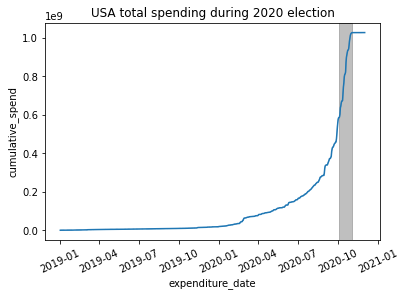

In [11]:
ax = sns.lineplot(x = "expenditure_date", y = "cumulative_spend", data = ind_spendings);

# Highlight region between 1 month before election date
start, end = pd.to_datetime('10-03-2020'), pd.to_datetime('11-03-2020')
plt.axvspan(start, end, color='gray', alpha=0.5)

plt.xticks(rotation = 25)
plt.title("USA total spending during 2020 election")
plt.show()

We see the rapid increase in overall candidate spending as the final election approaches.

Now lets observe the difference in spending by the two presidential candidates

In [12]:
trump_df = ind_spendings[ind_spendings['candidate_name'] == 'TRUMP, DONALD J.']
biden_df = ind_spendings[ind_spendings['candidate_name'] == 'BIDEN, JOSEPH R. JR']

# add cumulative spending
trump_df.loc[:, 'cumulative_spend'] = np.cumsum(trump_df['expenditure_amount'])
biden_df.loc[:, 'cumulative_spend'] = np.cumsum(biden_df['expenditure_amount'])

/Users/brianlin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


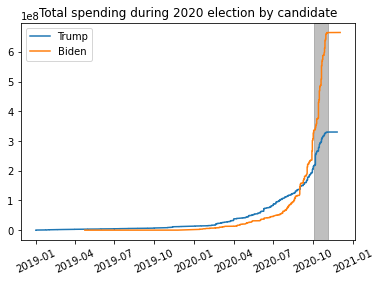

In [13]:
plt.plot(trump_df["expenditure_date"], trump_df["cumulative_spend"], label='Trump');
plt.plot(biden_df["expenditure_date"], biden_df["cumulative_spend"], label='Biden');

start, end = pd.to_datetime('10-03-2020'), pd.to_datetime('11-03-2020')
plt.axvspan(start, end, color='gray', alpha=0.5)

plt.xticks(rotation = 25)
plt.title("Total spending during 2020 election by candidate")
plt.legend()
plt.show()

Wow, Biden almost spending double the amount Trump has spent overall in the election. Let observe the spending amount in swing states

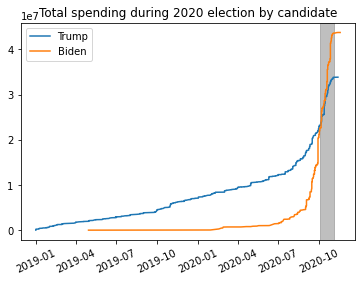

In [14]:
swing_states = ['AZ', 'FL', 'GA', 'IA', 'MI', 'MN', 'NV', 'NH', 'NC', 'OH', 'PA', 'TX', 'WI']

trump_df = trump_df[trump_df['payee_state'].isin(swing_states)]
biden_df = biden_df[biden_df['payee_state'].isin(swing_states)]

# add cumulative spending
trump_df.loc[:, 'cumulative_spend'] = np.cumsum(trump_df['expenditure_amount'])
biden_df.loc[:, 'cumulative_spend'] = np.cumsum(biden_df['expenditure_amount'])

plt.plot(trump_df["expenditure_date"], trump_df["cumulative_spend"], label='Trump');
plt.plot(biden_df["expenditure_date"], biden_df["cumulative_spend"], label='Biden');

start, end = pd.to_datetime('10-03-2020'), pd.to_datetime('11-03-2020')
plt.axvspan(start, end, color='gray', alpha=0.5)

plt.xticks(rotation = 25)
plt.title("Total spending during 2020 election by candidate")
plt.legend()
plt.show()

We see that Biden's political tatic is to aggressively spend money the closer the election gets while Trump spend a very consistent amount.

In [15]:
# now lets explore the top five highest spending candidates and how they spend on swing states
# Top Five Spenders: 'BIDEN, JOSEPH R. JR', 'TRUMP, DONALD J.', 'WARREN, ELIZABETH', 'SANDERS, BERNARD', 'BUTTIGIEG, PETE'
# Swing States: Arizona, Florida, Georgia, Iowa, Michigan, Minnesota, Nevada, 
# New Hampshire, North Carolina, Ohio, Pennsylvania, Texas, Wisconsin
top_5_list = [
    'BIDEN, JOSEPH R. JR', 
    'TRUMP, DONALD J.', 
    'WARREN, ELIZABETH', 
    'SANDERS, BERNARD', 
    'BUTTIGIEG, PETE'
]
swing_states = ['AZ', 'FL', 'GA', 'IA', 'MI', 'MN', 'NV', 'NH', 'NC', 'OH', 'PA', 'TX', 'WI']

top5_swing_only = ind_spendings[ind_spendings['candidate_name'].isin(top_5_list) & 
                                ind_spendings['payee_state'].isin(swing_states)]
top5_swing_totals = top5_swing_only.groupby(['candidate_name', 'payee_state']).sum()
top5_swing_totals.loc[:, ['expenditure_amount']]

expenditure_amount
candidate_name      payee_state                    
BIDEN, JOSEPH R. JR AZ                   1176050.42
                    FL                  12906825.63
                    GA                   1893239.36
                    IA                    438953.19
                    MI                    397994.05
                    MN                   1123541.70
                    NC                  10125710.11
                    NH                     49438.55
                    NV                   1745013.62
                    OH                   5290618.10
                    PA                   3254184.07
                    TX                   4598031.14
                    WI                    752322.00
BUTTIGIEG, PETE     NC                     24100.00
SANDERS, BERNARD    AZ                      4285.92
                    FL                     33356.10
                    IA                       940.07
                    MI                     10000.00
                    MN                     57214.42
                    NH                      1579.45
                    PA                      8895.00
                    TX                       148.35
                    WI                        20.00
TRUMP, DONALD J.    AZ                    130980.04
                    FL                  16301364.18
                    GA                    753865.88
                    IA                   3934727.38
                    MI                   1726241.66
                    MN                     55512.31
                    NC                   1306700.75
                    NH                     46684.87
                    NV                   1703614.37
                    OH                   4079862.86
                    PA                   1426529.81
                    TX                   1416232.54
                    WI                    976954.55
WARREN, ELIZABETH   NC                       903.27

Next, we are interested in comparing the spendings in swing states for Trump and Biden. We created two bargraphs showing the raw spending amount for each of the swing states as well as showing the proportion of their spending in each swing state to the total amount the candidate spent in their campaign.

/Users/brianlin/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


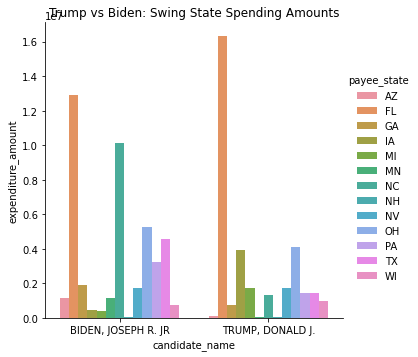

In [16]:
# now lets turn our focus to the main two candidates: Trump and Biden
cand_list = ['BIDEN, JOSEPH R. JR', 'TRUMP, DONALD J.']
top5_swing_totals = top5_swing_totals.reset_index()
plt_tbl = top5_swing_totals[top5_swing_totals['candidate_name'].isin(cand_list)]

sns.factorplot(
    x='candidate_name', 
    y='expenditure_amount', 
    hue='payee_state', 
    data=plt_tbl, 
    kind='bar'
).set(title = 'Trump vs Biden: Swing State Spending Amounts');

/var/folders/__/765s8f01353grpysl5ccy5q80000gn/T/ipykernel_78686/4285419696.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plt_tbl["spending_prop"] = new_col
/Users/brianlin/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


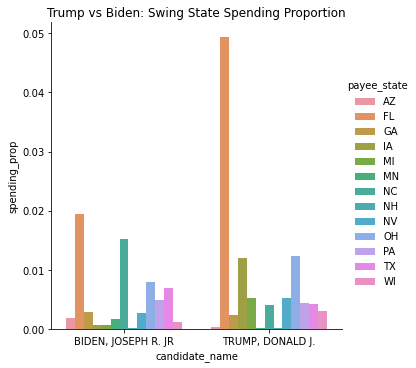

In [17]:
# now lets make the same graph as above but as a proportion of total spending for each candidate
trump_total = total_spendings[total_spendings['candidate_name']=='TRUMP, DONALD J.']['expenditure_amount']
biden_total = total_spendings[total_spendings['candidate_name']=='BIDEN, JOSEPH R. JR']['expenditure_amount']

temp = plt_tbl.apply(lambda row: row['expenditure_amount']/ trump_total if row['candidate_name']=='TRUMP, DONALD J.' else row['expenditure_amount'] / biden_total, axis = 1)
new_col = pd.concat([temp[0:13][0], temp[13:37][1]])
plt_tbl["spending_prop"] = new_col

sns.factorplot(
    x='candidate_name',
    y="spending_prop", 
    hue='payee_state', 
    data=plt_tbl, 
    kind='bar'
).set(title = 'Trump vs Biden: Swing State Spending Proportion');

In [18]:
plt_tbl[['candidate_name', 'expenditure_amount']].groupby('candidate_name').sum()

,expenditure_amount
candidate_name,
"BIDEN, JOSEPH R. JR",43751921.94
"TRUMP, DONALD J.",33859271.20


In [19]:
plt_tbl[['candidate_name', 'spending_prop']].groupby('candidate_name').sum()

,spending_prop
candidate_name,
"BIDEN, JOSEPH R. JR",0.065774
"TRUMP, DONALD J.",0.102534


In [20]:
plt_tbl = plt_tbl[['candidate_name', 'payee_state', 'expenditure_amount', 'spending_prop']]
who_won_col = ['Biden', 'Trump', 'Biden', 'Trump', 'Biden', 'Biden', 'Trump', 'Biden', 'Biden', 'Trump', 'Biden', 'Trump', 'Biden']
state_spending = pd.pivot_table(plt_tbl, values='expenditure_amount', index=['payee_state'], columns = 'candidate_name').reset_index()
who_spent_more_col = ['Biden' if x else 'Trump' for x in (state_spending['BIDEN, JOSEPH R. JR'] - state_spending['TRUMP, DONALD J.'] > 0).tolist()]
state_spending['Who Spent More']= who_spent_more_col
state_spending['State Result'] = who_won_col

same_result = sum(state_spending['Who Spent More'] == state_spending['State Result'])

display(f"Spent more and won: {same_result}")
state_spending

'Spent more and won: 8'

candidate_name,payee_state,"BIDEN, JOSEPH R. JR","TRUMP, DONALD J.",Who Spent More,State Result
0,AZ,1176050.42,130980.04,Biden,Biden
1,FL,12906825.63,16301364.18,Trump,Trump
2,GA,1893239.36,753865.88,Biden,Biden
3,IA,438953.19,3934727.38,Trump,Trump
4,MI,397994.05,1726241.66,Trump,Biden
5,MN,1123541.70,55512.31,Biden,Biden
6,NC,10125710.11,1306700.75,Biden,Trump
7,NH,49438.55,46684.87,Biden,Biden
8,NV,1745013.62,1703614.37,Biden,Biden
9,OH,5290618.10,4079862.86,Biden,Trump


In [21]:
exp_type = spendings[['candidate_name', 'payee_state', 'support_oppose_indicator', 
                      'expenditure_description', 'expenditure_amount']]
exp_type = exp_type[exp_type['payee_state'].isin(swing_states)]
exp_type.head()

,candidate_name,payee_state,support_oppose_indicator,expenditure_description,expenditure_amount
1,"BIDEN, JOSEPH R. JR",FL,S,CANVASSING,360.00
7,"BIDEN, JOSEPH R. JR",AZ,S,SALARY,19.79
14,"TRUMP, DONALD J.",OH,S,ESTIMATED AUGUST PHONE VOTER CONTACT,10000.00
15,"TRUMP, DONALD J.",PA,O,PHONE BANK (ESTIMATE),21.00
26,"BIDEN, JOSEPH R. JR",FL,S,RESEARCH (ESTIMATE),12500.00


In [22]:
biden_df = exp_type[exp_type['candidate_name'] == 'BIDEN, JOSEPH R. JR']
trump_df = exp_type[exp_type['candidate_name'] == 'TRUMP, DONALD J.']

biden_exp = biden_df.groupby(['expenditure_description']).agg(
    {'expenditure_amount': ['sum'], 'support_oppose_indicator': ['count']})
trump_exp = trump_df.groupby(['expenditure_description']).agg(
    {'expenditure_amount': ['sum'], 'support_oppose_indicator': ['count']})

In [23]:
biden_exp

,expenditure_amount,support_oppose_indicator
,sum,count
expenditure_description,,
2020 IE PRODUCTION COST FOR DIGITAL ADS,32250.00,1
30 SECOND RADIO ADVERTISEMENT TO OPPOSE VOTING FOR JOE BIDDEN,2000.00,1
AD BUY (ESTIMATE),467581.56,12
AD PLACEMENT,437000.00,2
AD PRODUCTION,9000.00,2
...,...,...
VOTERFILE DATA (ESTIMATE),46639.34,1
WAGES,4223.16,14


In [24]:
trump_exp

,expenditure_amount,support_oppose_indicator
,sum,count
expenditure_description,,
"RADIO ADS, PRODUCTION AND PLACEMENT",16709.80,1
2 BILLBOARD SIGNS,5900.00,1
2020 IE PRODUCTION COST FOR DIGITAL ADS,10750.00,1
60 SECOND AD BUY FOX NEWS SUNDAY,680.00,1
60 SECOND AD BUY MADISON,720.00,1
...,...,...
VOTER GUIDE DESIGN,100.00,1
VOTER ID PHONE CALLS,1058.24,1


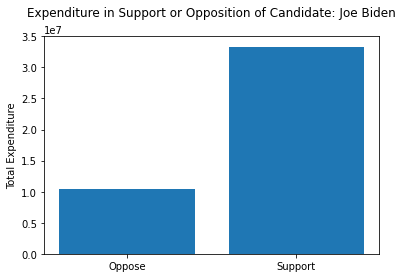

In [25]:
# biden support/oppose expenditure
biden_so_overall = biden_df.groupby(['support_oppose_indicator']).agg(sum)
biden_so_swing = biden_df.groupby(['payee_state', 'support_oppose_indicator']).agg(sum)

# visualize biden's expenditure in swing states
plt.bar(biden_so_overall.index, biden_so_overall['expenditure_amount'], tick_label=['Oppose', 'Support'])
plt.title("Expenditure in Support or Opposition of Candidate: Joe Biden", pad=20)
plt.ylabel('Total Expenditure')
plt.show()

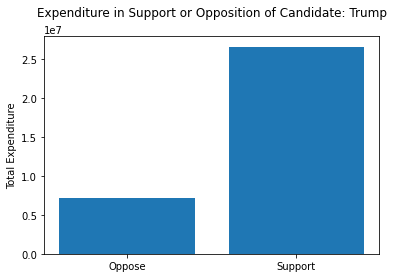

In [26]:
# trump support/oppose expenditure
trump_so_overall = trump_df.groupby(['support_oppose_indicator']).agg(sum)
trump_so_swing = trump_df.groupby(['payee_state', 'support_oppose_indicator']).agg(sum)

# visualize trumps's expenditure in swing states
plt.bar(trump_so_overall.index, trump_so_overall['expenditure_amount'], tick_label=['Oppose', 'Support'])
plt.title("Expenditure in Support or Opposition of Candidate: Trump", pad=20)
plt.ylabel('Total Expenditure')
plt.show()

### Voting Preferences

First explore the ratio of how different the race ratio of the candidates are and analyze whether there are differences between office type.

In [27]:
win = dem[dem['Won Primary'] == 'Yes']
elected_ratio = []
nonelected_ratio = []
for i in range(10,100,5):
    elected_ratio.append(win[win["Primary %"] > i]['Elected Official?'].value_counts()[0]/len(win[win["Primary %"] > i]))
    nonelected_ratio.append(win[win["Primary %"] > i]['Elected Official?'].value_counts()[1]/len(win[win["Primary %"] > i]))

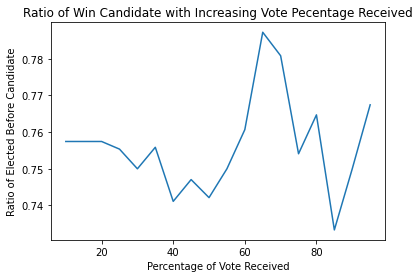

In [28]:
plt.plot(range(10,100,5), elected_ratio)
plt.title('Ratio of Win Candidate with Increasing Vote Pecentage Received')
plt.xlabel('Percentage of Vote Received')
plt.ylabel('Ratio of Elected Before Candidate');

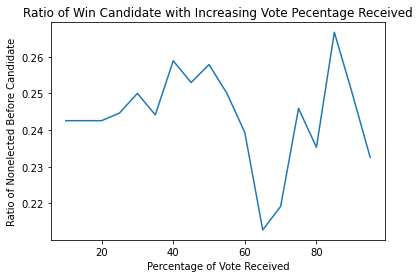

In [29]:
plt.plot(range(10,100,5), nonelected_ratio)
plt.title('Ratio of Win Candidate with Increasing Vote Pecentage Received')
plt.xlabel('Percentage of Vote Received')
plt.ylabel('Ratio of Nonelected Before Candidate');

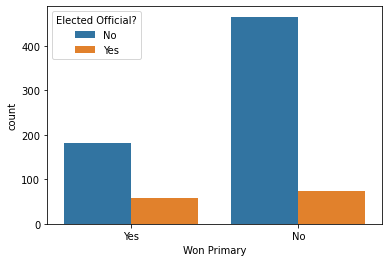

In [30]:
sns.countplot(x="Won Primary", data=dem, order=['Yes', 'No'], hue='Elected Official?');

From the three plots above, we could assume that there candidate that is elected before is more likely to receive 60-70% of votes and the candidate is more likely to win if he is elected before compared to not elected before.

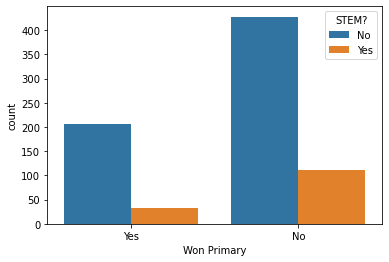

In [31]:
sns.countplot(x = "Won Primary", data = dem, order = ['Yes', 'No'], hue = 'STEM?');

We could also see that the proportion of Stem candidate that win the primary is less than Stem candidate that lose the primary.

Now let's observe the candidate's preference for gun regulation

In [32]:
dem['Guns Sense Candidate?'].value_counts()/len(dem)

Yes    0.237978
No     0.221948
Name: Guns Sense Candidate?, dtype: float64

<AxesSubplot:xlabel='Won Primary', ylabel='count'>

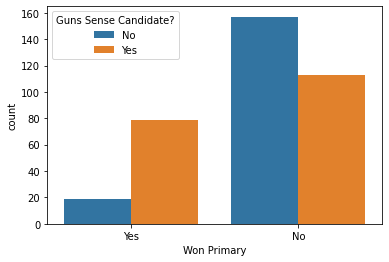

In [33]:
sns.countplot(x = "Won Primary", data = dem, order = ['Yes', 'No'], hue = 'Guns Sense Candidate?')

In [34]:
drop_na = dem.dropna(subset = ['Guns Sense Candidate?', 'Won Primary'])

nogun_win_ratio = len(drop_na[(drop_na["Guns Sense Candidate?"] == "Yes") & 
                           (drop_na["Won Primary"] == "Yes")])/len(drop_na[drop_na["Won Primary"] == "Yes"])
nogun_lose_ratio = len(drop_na[(drop_na["Guns Sense Candidate?"] == "Yes") & 
                           (drop_na["Won Primary"] == "No")])/len(drop_na[drop_na["Won Primary"] == "No"])
nogun_win_ratio, nogun_lose_ratio

(0.8061224489795918, 0.4185185185185185)

From the bar chart and ratio number above, we conclude that supporting gun safety could have an affect on whether voters side with democratic candidates.

## Methods to Answer Q1: 
### GLM Model - Logistic Regression

We chose logistic regression as our GLM model since it can use to predict binary outcome, which is win or lose in this scenario. The assumption we made is the sample size is large enough to fit the model, the observations are all independent of each other.

In [40]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
clean = dem[['Won Primary', 'Self-Funder?', 'Guns Sense Candidate?', 'STEM?', 'Elected Official?']].dropna()

final_x = clean[['Self-Funder?', 'Guns Sense Candidate?', 'STEM?', 'Elected Official?']]
cats = final_x.select_dtypes(include=['object']).columns.tolist()
nums = final_x.select_dtypes(include=[np.number]).columns.tolist()
final_y = clean[['Won Primary']]
final_cat = pd.get_dummies(final_x[cats], drop_first= True)
final_y = pd.get_dummies(final_y[['Won Primary']], drop_first = True)

# final_num=preprocessing.scale(final_x[nums])
# final_num=pd.DataFrame(final_num, columns = ['Primary %'])
# final_num = final_num.reset_index(drop = True)

final_X = final_cat.reset_index(drop = True)
#final_X = pd.concat([final_X, final_num], axis = 1)
final_X = final_X[['Guns Sense Candidate?_Yes', 'STEM?_Yes','Elected Official?_Yes', 'Self-Funder?_Yes']]
final_X = sm.add_constant(final_X)

X_train, X_test, y_train, y_test = train_test_split(final_X, final_y, test_size=0.33, random_state=42)

/Users/brianlin/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [41]:
final_X

,const,Guns Sense Candidate?_Yes,STEM?_Yes,Elected Official?_Yes,Self-Funder?_Yes
0,1.0,0,0,0,0
1,1.0,0,0,0,0
2,1.0,0,0,0,0
3,1.0,0,0,1,0
4,1.0,0,0,1,0
...,...,...,...,...,...
357,1.0,1,0,1,0
358,1.0,1,0,0,0
359,1.0,1,1,0,0
360,1.0,1,1,0,1


In [42]:
X_train, y_train = X_train.values.tolist(), y_train.values.tolist()

In [43]:
model1 = sm.GLM(
    y_train, X_train,
    family = sm.families.Binomial())
results = model1.fit()
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  242
Model:                            GLM   Df Residuals:                      237
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -124.58
Date:                Mon, 13 Dec 2021   Deviance:                       249.15
Time:                        20:10:07   Pearson chi2:                     233.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.1686      0.356     -6.090      0.0

In [44]:
from sklearn import metrics
y_pred = results.predict(X_test)
y_pred = [ 0 if x < 0.5 else 1 for x in y_pred]
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[84,  2],
       [33,  1]])

In [45]:
from sklearn.metrics import classification_report
matrix = classification_report(y_test, y_pred)
print('Classification report : \n', matrix)

Classification report : 
               precision    recall  f1-score   support

           0       0.72      0.98      0.83        86
           1       0.33      0.03      0.05        34

    accuracy                           0.71       120
   macro avg       0.53      0.50      0.44       120
weighted avg       0.61      0.71      0.61       120



### Nonparametric Model - AdaBoost Classifier

We first try different nonparametric models such as decision tree, random forestm gradientboosing, Adaboost, GaussianNB. And then we compare their results to pick the best performance. The assumption we made here is that the observations are all independent of each other.

We will evaluate the model's performance by precision, recall, accuracy, f1-score.

In [46]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold, StratifiedKFold

In [47]:
models = [LogisticRegression(),
    DecisionTreeClassifier(),
    GaussianNB(),
    RandomForestClassifier(),
    AdaBoostClassifier(),  
    GradientBoostingClassifier()] 

titles = ['Log', 'DT',  'NB', 'RF', 'AdaBoost', 'Gradient']

In [48]:
model_comp1 = pd.DataFrame()
cv = StratifiedKFold(n_splits=8)

for i, model in enumerate(models):
    model_comp1[titles[i]] = cross_val_score(model, final_X, final_y, 
                                            scoring = 'f1_weighted', cv = cv)

/Users/brianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/brianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/brianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/brianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please

/Users/brianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/brianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/brianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/brianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please

In [49]:
model_comp1

,Log,DT,NB,RF,AdaBoost,Gradient
0,0.695260,0.588629,0.676680,0.588629,0.710870,0.588629
1,0.588629,0.599340,0.662681,0.588629,0.588629,0.599340
2,0.665485,0.620513,0.650000,0.665485,0.665485,0.620513
3,0.650000,0.650000,0.603451,0.650000,0.650000,0.650000
4,0.761905,0.620513,0.743409,0.620513,0.761905,0.620513
5,0.683272,0.620513,0.714286,0.620513,0.714286,0.620513
6,0.598246,0.609524,0.598246,0.598246,0.598246,0.609524
7,0.696889,0.609524,0.665485,0.609524,0.696889,0.609524


In [50]:
np.mean(model_comp1)

Log         0.667461
DT          0.614819
NB          0.664280
RF          0.617692
AdaBoost    0.673289
Gradient    0.614819
dtype: float64

In [51]:
model_comp2 = pd.DataFrame()
for i, model in enumerate(models):
    model_comp2[titles[i]] = cross_val_score(model, final_X, final_y, 
                                            scoring = 'accuracy', cv = cv)

/Users/brianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/brianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/brianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/brianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please

/Users/brianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/brianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/brianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/brianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please

In [52]:
np.mean(model_comp2)

Log         0.721014
DT          0.715519
NB          0.698913
RF          0.709964
AdaBoost    0.723792
Gradient    0.715519
dtype: float64

After comparison between each model, AdaBoost has the highest accuracy score and f-1 score, so I pick it as my nonparametric model.

In [53]:
model_ada = AdaBoostClassifier()
model_ada.fit(X_train, y_train)
probs = model_ada.predict_proba(X_test)[:, 1]
y_pred = (probs > 0.5).astype(np.int64)
matrix = classification_report(y_test, y_pred)
print('Classification report : \n', matrix)

Classification report : 
               precision    recall  f1-score   support

           0       0.72      0.98      0.83        86
           1       0.33      0.03      0.05        34

    accuracy                           0.71       120
   macro avg       0.53      0.50      0.44       120
weighted avg       0.61      0.71      0.61       120



/Users/brianlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


### Results - GLM & Nonparametrics

Our logistic regression model has a 72% accuracy score and 66% f1 score, with two statistically significant variables in 0.1 level, which are 'Gun Senses Candidate?' and 'Stem?'. It is a postive coefficient for gun support variable and negative coefficient for stem varaible.

My Adaboost model has a 72% accuracy score amd 67% f1 score, which is slightly better than my parametric model.

To estimate the uncertainty of my logistic regression model, we could look at the confidence interval of the coefficient of 'Gun Senses Candidate?' and 'STEM?', which are 1.74 and -0.65. It means that the there is a 174% increases in odds of winning the election if the candidate support gun safety and 65% decreases in odds of winning the election if the candidate is STEM major. For the interval of the odds ratio of 'Gun Senses Candidate?', there is a 95% chance between 2.6 to 12.24. For the interval of the odds ratio of 'STEM?', there is a 95% chance between 0.23 and 1.17. 

In [54]:
np.exp(1.7474+2*0.379), np.exp(1.7474-2*0.379), np.exp(-0.6508+2*0.405), np.exp(-0.6508-2*0.405)

(12.248457369002674, 2.689620215991188, 1.172572437718376, 0.23205056000576937)

### Discussion - GLM & Nonparametrics

Our Adaboost model performed better since it has better performance by adjusting the weight of incorrect classification the second time they fit the model. We are 70% confident in applying this model to the future datasets. There are limitations of our models, such as it does not perform extremely well and might need more variables to improve the models. The models are easy to be wrong since there are only four variables to train for now. If the backgrounds of the voters or the location of the election are different, the predictions might be incorrect. Additional data such as their education level, their number of attendance of their rally, age, might be useful for improving our models.

## Method to Answer Q2: 
### Causal Inference - Prepping and Feature Engineering

In [55]:
# number of electoral college votes for swing states that which included in analysis
state_votes = {'AZ':11, 'FL':29, 'GA':16, 'MI':16, 'MN':10, 'NV':6, 'NH':4, 'NC':15, 'PA':20, 'TX':38, 'WI':10,
               "OH": 18, 'ME': 4, 'VA':13, 'IA':6, 'CO':9, 'IN':11, 'NM':5, 'MO':10}

# swing states and their election results for each election year
swing_states_2020 = ['AZ', 'FL', 'GA', 'MI', 'MN', 'NV', 'NH', 'NC', 'PA', 'TX', 'WI']
swing_res_2020 = {'AZ':0.0031, 'FL':-0.0336, 'GA':0.0024, 'MI':0.0278, 'MN':0.0711, 'NV':0.0239,
                  'NH':0.0735, 'NC':-0.0135, 'PA':0.0116, 'TX':-0.0558, 'WI':0.0063}

swing_states_2016 = ['AZ', 'FL', 'GA', 'MI', 'MN', 'NV', 'NH', 'NC', 'PA', 'ME', 'WI']
swing_res_2016 = {'AZ':-0.0355, 'FL':-0.0120, 'GA':-0.0513, 'MI':-0.0023, 'MN':0.0152, 'NV':0.0242,
                  'NH':0.0037, 'NC':-0.0366, 'PA':-0.0072, 'ME':0.0296, 'WI':-0.0077, 'TX': 0.1579}

swing_states_2012 = ['VA', 'FL', 'GA', 'IA', 'OH', 'NV', 'NH', 'NC', 'PA', 'CO', 'WI']
swing_res_2012 = {'VA':0.0387, 'FL':0.0088, 'GA':-0.0782, 'IA':0.0581, 'OH':0.0298, 'NV':0.0668,
                  'NH':0.0558, 'NC':-0.0204, 'PA':0.0539, 'CO':0.0537, 'WI':0.0694, 'AZ': -0.0906, 'MI': 0.0950,
                  'MN': 0.0769, 'ME': 0.1529}

swing_states_2008 = ['VA', 'FL', 'IN', 'IA', 'OH', 'NV', 'NH', 'NC', 'PA', 'CO', 'MN']
swing_res_2008 = {'VA':0.0630, 'FL':0.0282, 'IN':0.0103, 'IA':0.0953, 'OH':0.0459, 'NV':0.1249,
                  'NH':0.0961, 'NC':0.0033, 'PA':0.1032, 'CO':0.0895, 'MN':0.1024, 'WI': 0.1391, 'GA': -0.0521}

swing_states_2004 = ['VA', 'FL', 'NM', 'IA', 'OH', 'NV', 'NH', 'WI', 'PA', 'CO', 'MO']
swing_res_2004 = {'VA':-0.0820, 'FL':-0.0501, 'NM':-0.0079, 'IA':-0.0067, 'OH':-0.0211, 'NV':-0.0259,
                  'NH':0.0137, 'WI':0.0038, 'PA':0.0250, 'CO':-0.0467, 'MO':-0.0720, 'IN': -0.2038, 'NC': -0.1244,
                  'MN': -0.0448}

swing_res_2000 = {'VA':-0.0803, 'FL':-0.0001, 'NM':0.0006, 'IA':0.0034, 'OH':-0.0351, 'NV':-0.0354,
                  'NH':-0.0127, 'WI':0.0122, 'PA':0.0417, 'CO':-0.0836, 'MO':-0.0334}

***Functions used to engineer features***

In [56]:
# function which returns a dataframe with the treatment, outcome, and confounders as columns
# swing_res => positive is in favor of dem, negative is in favor of rep

def make_state_spending_tbl(ind_expend, dem_cand_id, rep_cand_id, swing_states):
    two_cand = ind_expend[(ind_expend['candidate_id'] == dem_cand_id) | (ind_expend['candidate_id'] == rep_cand_id)]
    two_cand = two_cand[two_cand['payee_state'].isin(swing_states)].groupby(['candidate_id', 'payee_state']).sum()
    state_spending = pd.pivot_table(two_cand.reset_index(), values='expenditure_amount', index=['payee_state'],
                                    columns = 'candidate_id').reset_index().fillna(0)
    return state_spending

def make_causal_tbl(ind_expend, prev_expend, dem_cand_id, rep_cand_id, prev_dem_cand_id, prev_rep_cand_id,
                    swing_states, swing_res, prev_swing_res, year):
    
    state_spending = make_state_spending_tbl(ind_expend, dem_cand_id, rep_cand_id, swing_states)
    
    dem_spent_more_col = [int(x) for x in (state_spending[dem_cand_id] - state_spending[rep_cand_id] > 0).tolist()]
    res_col = [swing_res[s] for s in swing_states]
    electoral_votes_col  = [state_votes[s] for s in swing_states]
    prev_result_col = [prev_swing_res[s] for s in swing_states]
    prev_spending_col = [np.nan for i in range(11)]
    if year > 2004:
        prev_state_spending = make_state_spending_tbl(prev_expend, prev_dem_cand_id, prev_rep_cand_id, swing_states)
        prev_spending_col = (prev_state_spending[prev_dem_cand_id] - prev_state_spending[prev_rep_cand_id]).tolist()

    state_spending['year'] = [year for i in range(11)]
    state_spending['dem_spent_more'] = dem_spent_more_col # treatment
    state_spending['prev_spending_diff']= prev_spending_col # confounder
    state_spending['electoral_votes'] = electoral_votes_col # confounder
    state_spending['prev_dem_election_result'] = prev_result_col # confounder
    state_spending['dem_election_result'] = res_col # outcome
    
    state_spending = state_spending.rename(columns = {dem_cand_id: "dem_spent", rep_cand_id:'rep_spent'})
    return state_spending

**Making Table For Each Year**

Includes which party spent more (treatment var; 1 for dem, 0 for rep), election results (outcome var; margin of victory for democratic candidate in percentage), and difference in dem vs rep spending previous election (confounder), election result of prev cycle (confounder.

**Notes:**
- Data from: https://www.fec.gov/data/independent-expenditures/?most_recent=true&data_type=processed&is_notice=true
    - only included expenditures starting from 2004
- Data for each election year includes independent expeditures between Jan 1 of year before election to Dec 31 of the election year. e.g. 2020_independent_expenditures.csv includes expenditures between 1/1/2019 - 12/31/2020.

In [57]:
# loading in data

# 2020: trump candidate_id = P80001571, biden candidate_id = P80000722
ind_expend_2020 = pd.read_csv('data/2020_independent_expenditures.csv')
ind_expend_2020 = ind_expend_2020[['candidate_id','candidate_name','expenditure_amount','payee_state']]

# 2016: trump candidate_id = P80001571, clinton candidate_id = P00003392

ind_expend_2016 = pd.read_csv('data/2016_independent_expenditures.csv')
ind_expend_2016 = ind_expend_2016[['candidate_id','candidate_name','expenditure_amount','payee_state']]

# 2012: romney candidate_id = P80003353, obama candidate_id = P80003338

ind_expend_2012 = pd.read_csv('data/2012_independent_expenditures.csv')
ind_expend_2012 = ind_expend_2012[['candidate_id','candidate_name','expenditure_amount','payee_state']]

# 2008: mccain candidate_id = P80002801, obama candidate_id = P80003338
ind_expend_2008 = pd.read_csv('data/2008_independent_expenditures.csv')
ind_expend_2008 = ind_expend_2008[['candidate_id','candidate_name','expenditure_amount','payee_state']]

# 2004: bush candidate_id = P00003335, kerry candidate_id = P80000235

ind_expend_2004 = pd.read_csv('data/2004_independent_expenditures.csv')
ind_expend_2004 = ind_expend_2004[['candidate_id','candidate_name','expenditure_amount','payee_state']]

/Users/brianlin/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (54,55,67) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/brianlin/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (38,67,68) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/brianlin/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (15,35,67,68,72) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [58]:
state_spending_2020 = make_causal_tbl(ind_expend_2020, ind_expend_2016, 'P80000722', 'P80001571', 'P00003392',
                                      'P80001571', swing_states_2020, swing_res_2020, swing_res_2016, 2020)
state_spending_2020

candidate_id,payee_state,dem_spent,rep_spent,year,dem_spent_more,prev_spending_diff,electoral_votes,prev_dem_election_result,dem_election_result
0,AZ,1173527.31,913990.13,2020,1,-4619.63,11,-0.0355,0.0031
1,FL,13315256.33,14482193.99,2020,0,-36393.19,29,-0.0120,-0.0336
2,GA,1800522.49,700054.46,2020,1,-727485.47,16,-0.0513,0.0024
3,MI,182189.58,1777511.06,2020,0,-169656.73,16,-0.0023,0.0278
4,MN,1358944.03,523982.38,2020,1,158189.84,10,0.0152,0.0711
5,NC,11720622.71,1465130.97,2020,1,695134.06,6,0.0242,0.0239
6,NH,99622.57,7575.16,2020,1,-36121.40,4,0.0037,0.0735
7,NV,1704718.31,1719220.87,2020,0,136177.02,15,-0.0366,-0.0135
8,PA,2879102.53,3427903.30,2020,0,1527823.83,20,-0.0072,0.0116
9,TX,4804806.92,1728583.87,2020,1,-7905397.47,38,0.1579,-0.0558


In [59]:
state_spending_2016 = make_causal_tbl(ind_expend_2016, ind_expend_2012, 'P00003392', 'P80001571','P80003338',
                                      'P80003353', swing_states_2016, swing_res_2016, swing_res_2012, 2016)
state_spending_2016

candidate_id,payee_state,dem_spent,rep_spent,year,dem_spent_more,prev_spending_diff,electoral_votes,prev_dem_election_result,dem_election_result
0,AZ,201262.23,205881.86,2016,0,297777.90,11,-0.0906,-0.0355
1,FL,945751.57,982144.76,2016,0,180957.77,29,0.0088,-0.0120
2,GA,101121.80,828607.27,2016,0,-1066098.29,16,-0.0782,-0.0513
3,ME,7300.00,4430.00,2016,1,9133.69,16,0.0950,-0.0023
4,MI,51335.58,220992.31,2016,0,7572.95,10,0.0769,0.0152
5,MN,164836.03,6646.19,2016,1,897891.70,6,0.0668,0.0242
6,NC,882597.65,187463.59,2016,1,1753574.27,4,0.0558,0.0037
7,NH,17687.75,53809.15,2016,0,-374399.14,15,-0.0204,-0.0366
8,NV,175124.24,38947.22,2016,1,57034.05,20,0.0539,-0.0072
9,PA,2571707.27,1043883.44,2016,1,-2761547.19,4,0.1529,0.0296


In [60]:
state_spending_2012 = make_causal_tbl(ind_expend_2012, ind_expend_2008, 'P80003338', 'P80003353', 'P80003338',
                                      'P80002801', swing_states_2012, swing_res_2012, swing_res_2008, 2012)
state_spending_2012

candidate_id,payee_state,dem_spent,rep_spent,year,dem_spent_more,prev_spending_diff,electoral_votes,prev_dem_election_result,dem_election_result
0,CO,2.124631e+06,317252.04,2012,1,2352202.33,13,0.0630,0.0387
1,FL,2.489547e+06,2308589.59,2012,1,1377115.26,29,0.0282,0.0088
2,GA,8.491136e+05,1915211.88,2012,0,-435001.01,16,-0.0521,-0.0782
3,IA,3.085803e+05,64340.25,2012,1,368600.19,6,0.0953,0.0581
4,NC,2.262080e+06,508505.71,2012,1,65643.30,18,0.0459,0.0298
5,NH,3.198600e+02,374719.00,2012,0,2779.82,6,0.1249,0.0668
6,NV,1.270904e+05,70056.33,2012,1,117710.24,4,0.0961,0.0558
7,OH,1.803654e+07,972711.50,2012,1,1813970.78,15,0.0033,-0.0204
8,PA,8.922581e+05,3653805.32,2012,0,2956192.41,20,0.1032,0.0539
9,VA,1.645119e+08,31453048.52,2012,1,56447063.16,9,0.0895,0.0537


In [61]:
state_spending_2008 = make_causal_tbl(ind_expend_2008, ind_expend_2004, 'P80003338', 'P80002801','P80000235',
                                      'P00003335', swing_states_2008, swing_res_2008, swing_res_2004, 2008)
state_spending_2008

candidate_id,payee_state,rep_spent,dem_spent,year,dem_spent_more,prev_spending_diff,electoral_votes,prev_dem_election_result,dem_election_result
0,CO,1309422.91,3661625.24,2008,1,8716528.91,13,-0.0820,0.0630
1,FL,22631.95,1399747.21,2008,1,-1976042.81,29,-0.0501,0.0282
2,IA,0.00,368600.19,2008,1,-10313.28,11,-0.2038,0.0103
3,IN,1000.00,0.00,2008,0,-15884.97,6,-0.0067,0.0953
4,MN,102546.16,75692.13,2008,0,73126.97,18,-0.0211,0.0459
5,NC,49225.70,114869.00,2008,1,-71496.96,6,-0.0259,0.1249
6,NH,1726.91,4506.73,2008,1,-41979.38,4,0.0137,0.0961
7,NV,7783.51,125493.75,2008,1,-35505.62,15,-0.1244,0.0033
8,OH,77492.05,1891462.83,2008,1,-112317.21,20,0.0250,0.1032
9,PA,2745049.69,5701242.10,2008,1,218760.92,9,-0.0467,0.0895


In [62]:
state_spending_2004 = make_causal_tbl(ind_expend_2004, np.nan, 'P80000235', 'P00003335', np.nan, np.nan,
                                      swing_states_2004, swing_res_2004, swing_res_2000, 2004)
state_spending_2004

candidate_id,payee_state,rep_spent,dem_spent,year,dem_spent_more,prev_spending_diff,electoral_votes,prev_dem_election_result,dem_election_result
0,CO,1170636.96,9887165.87,2004,1,NaN,13,-0.0803,-0.0820
1,FL,2087700.86,111658.05,2004,0,NaN,29,-0.0001,-0.0501
2,IA,32586.81,22273.53,2004,0,NaN,5,0.0006,-0.0079
3,MO,3569.80,425.00,2004,0,NaN,6,0.0034,-0.0067
4,NH,43889.38,1910.00,2004,0,NaN,18,-0.0351,-0.0211
5,NM,167726.24,49548.67,2004,0,NaN,6,-0.0354,-0.0259
6,NV,45432.80,9927.18,2004,0,NaN,4,-0.0127,0.0137
7,OH,163493.70,51176.49,2004,0,NaN,10,0.0122,0.0038
8,PA,816497.32,1035258.24,2004,1,NaN,20,0.0417,0.0250
9,VA,3303158.50,13112089.82,2004,1,NaN,9,-0.0836,-0.0467


**Making full table with all years, normalizing confounders, and making election result binary**

In [63]:
def normalize(v):
    return (v - np.min(v)) / (np.max(v) - np.min(v))

In [64]:
full_tbl = pd.concat([state_spending_2004, state_spending_2008, state_spending_2012, state_spending_2016,
                      state_spending_2020]).drop(columns = ['rep_spent','dem_spent'])
full_tbl = full_tbl.fillna(np.mean(full_tbl['prev_spending_diff'])) # filling missing data for prev_spending_diff for 2004
full_tbl['prev_spending_diff'] = normalize(full_tbl['prev_spending_diff'])
full_tbl['prev_dem_election_result'] = normalize(full_tbl['prev_dem_election_result'])
full_tbl['dem_election_result_bi'] = (full_tbl['dem_election_result'] > 0).astype(int)
full_tbl

candidate_id,payee_state,year,dem_spent_more,prev_spending_diff,electoral_votes,prev_dem_election_result,dem_election_result,dem_election_result_bi
0,CO,2004,1,0.150746,13,0.341443,-0.0820,0
1,FL,2004,0,0.150746,29,0.563174,-0.0501,0
2,IA,2004,0,0.150746,5,0.565109,-0.0079,0
3,MO,2004,0,0.150746,6,0.572850,-0.0067,0
4,NH,2004,0,0.150746,18,0.466409,-0.0211,0
5,NM,2004,0,0.150746,6,0.465579,-0.0259,0
6,NV,2004,0,0.150746,4,0.528338,0.0137,1
7,OH,2004,0,0.150746,10,0.597180,0.0038,1
8,PA,2004,1,0.150746,20,0.678739,0.0250,1
9,VA,2004,1,0.150746,9,0.332320,-0.0467,0


### Causal Inference - Performing Inverse Propensity Score Weighting to estimate treatment effect.

**Model with treatment var being dem_spent_more, confounders being prev_dem_election_result & dem_election_result, and outcome var being dem_election_result_bi**

In [65]:
from sklearn.linear_model import LogisticRegression as LR

lr = LR(penalty='none', max_iter=200, random_state=0)
X = full_tbl[['prev_spending_diff', 'prev_dem_election_result']]
Z = full_tbl['dem_spent_more'] # treatment var
Y = full_tbl['dem_election_result_bi'] # outcome var
lr.fit(X,Z)

full_tbl['p_score'] = lr.predict_proba(X)[:,1]
cleaned_full_tbl = full_tbl[(full_tbl['p_score']<0.9) & (full_tbl['p_score']>0.1)] # only keep rows between 0.1 to 0.9
treated_rows = cleaned_full_tbl[cleaned_full_tbl['dem_spent_more'] == 1]
untreated_rows = cleaned_full_tbl[cleaned_full_tbl['dem_spent_more'] == 0]
weighted_sum_treated = np.sum(np.divide(treated_rows['dem_election_result_bi'], treated_rows['p_score']))
weighted_sum_untreated = np.sum(np.divide(untreated_rows['dem_election_result_bi'], 1 - untreated_rows['p_score']))
ipw_estimate = (weighted_sum_treated - weighted_sum_untreated)/len(cleaned_full_tbl)
ipw_estimate

0.2848950114574326

In [66]:
full_tbl

candidate_id,payee_state,year,dem_spent_more,prev_spending_diff,electoral_votes,prev_dem_election_result,dem_election_result,dem_election_result_bi,p_score
0,CO,2004,1,0.150746,13,0.341443,-0.0820,0,0.519507
1,FL,2004,0,0.150746,29,0.563174,-0.0501,0,0.563192
2,IA,2004,0,0.150746,5,0.565109,-0.0079,0,0.563570
3,MO,2004,0,0.150746,6,0.572850,-0.0067,0,0.565081
4,NH,2004,0,0.150746,18,0.466409,-0.0211,0,0.544207
5,NM,2004,0,0.150746,6,0.465579,-0.0259,0,0.544044
6,NV,2004,0,0.150746,4,0.528338,0.0137,1,0.556376
7,OH,2004,0,0.150746,10,0.597180,0.0038,1,0.569823
8,PA,2004,1,0.150746,20,0.678739,0.0250,1,0.585620
9,VA,2004,1,0.150746,9,0.332320,-0.0467,0,0.517698


Looking at the p_scores, most around 0.5 which means our logistic regression isn't doing a great job of predicting the treatment variable. This could mean several things. One reason could be that the confounding variables we chosen aren't correlated and most likely not actually confounders. Another reason is that the logistic model is not the best choice for classifying our treatment, which could also be because we don't have a lot of rows to train the data on. In any case, looking at the estimated treatment effect from IPW, there is roughly a 28.5% increase in the chance of the democratic candidate winning when the democratic candidate spends more than the republican candidates.